**This notebook trains and evaluates the baseline model**

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
import sys
from sklearn.metrics import roc_auc_score
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks import SaveModelCallback

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [4]:
# we wrap cadene model to pytorch models format
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [5]:
arch_summary(se_resnext101_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 278 layers (total: 370)
(4) Sequential  : 38  layers (total: 408)
(5) AvgPool2d   : 1   layers (total: 409)
(6) Linear      : 1   layers (total: 410)


Training parameters

In [6]:
BATCH_SIZE = 64
sz = 256
NUM_WORKERS = 16
model_name = '20190825-18-se_resnext101_32x4d_Test'

Use data augmentations that mimic the hue and color saturation variance caused by the different scanning instruments and staining procedures.

In [7]:
import random

def randomizeStaining(img, Io=240, alpha=1, beta=0.15, maxC1=None, maxC2=None):
    ''' Randomize staining appearence of H&E stained images
    
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    ε = 0.10
    θ = 4.0
    maxCRef = np.random.uniform(size=2) * θ + ε
    if maxC1 is not None:
        maxCRef[0] = maxC1
    if maxC2 is not None:
        maxCRef[1] = maxC2
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = None,None
    try:
        eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    except AssertionError:
        return img.reshape(sz,sz,3)
    except np.linalg.LinAlgError:
        return img.reshape(sz,sz,3)
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)
    
    return Inorm

In [8]:
albumentations_transform = albumentations.Compose([
    # flips and 90deg rotates
    albumentations.RandomRotate90(p=0.5),
    albumentations.Flip(p=0.5),
    
    # brightness contrast or gamma
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
        albumentations.RandomGamma(gamma_limit=(60, 200), always_apply=True, p=1),
    ],p=1.0),
    
    # scale
    #albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.1,0.1], rotate_limit=10, p=0.5),
    
    # color alterations
    albumentations.OneOf([
        albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=20, always_apply=True),
        albumentations.augmentations.transforms.RGBShift(r_shift_limit=30, g_shift_limit=15, b_shift_limit=30, always_apply=True),
        albumentations.augmentations.transforms.CLAHE(p=1),
        #albumentations.augmentations.transforms.ChannelShuffle()
    ],p=0.8),
    
    # Blurring or noise
    albumentations.OneOf([
        albumentations.GaussNoise(p=0.2),
        albumentations.augmentations.transforms.Blur(p=0.2)
    ],p=1.0),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

Custom image lists

In [9]:
class CustomImageList(ItemList):
    "`ItemList` suitable for computer vision that uses augmentations for training items but not for validation items"
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args, df_copy=None, validation_colname="", data_dir='',data_suffix='', convert_mode='RGB', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix, self.convert_mode,self.after_open = df_copy,validation_colname,data_dir,data_suffix,convert_mode,after_open
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 3,{}

    def get(self, i):
        fn = super().get(i)
        res = self.open(fn)
        self.sizes[i] = res.size
        return res
    
    def open(self, fn)->Image:
        img = cv2.imread(fn)
        # Apply transformations
        img = img if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix, ''))][self.validation_colname]).any() else randomizeStaining(img)
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix, ''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or ''
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add(pref, res.items.astype(str)), suffix)
        return res
    
    def reconstruct(self, t:Tensor): return Image(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [10]:
def getDataBunch(fold_index = 0):
    df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df['is_valid'] = True # set validation to True to avoid augmentations
    # Create ImageDataBunch using fastai data block API
    return (CustomImageList.from_df_custom(path='data/patches/',
                                            df=df,
                                            suffix='_0.png', 
                                            df_copy=df, 
                                            validation_colname='is_valid')
                    .split_none()
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
                    # convert to databunch
                    .normalize(imagenet_stats))

### Inference

In [11]:
def getLearner(dataBunch):
    learner =  cnn_learner(dataBunch,
                           se_resnext101_32x4d,
                           pretrained=True,
                           path='.',
                           metrics=[accuracy],
                           ps=0.9,
                           callback_fns=ShowGraph)

    learner.crit=nn.BCEWithLogitsLoss()
    return learner

In [12]:
learner = getLearner(getDataBunch(0))

In [13]:
from sklearn.metrics import roc_curve, auc

# saved for validation
preds_list = []
y_list = []

tpr_list = []
fpr_list = []
roc_auc_list = []

recorder_stage1_list = []

df_inference = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)

# Five times the test fold
for fold in range(5):
    print("##########################")
    print("Start Train inference - " + str(fold))
    print("##########################")
    
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=fold)
    
    # init new learner
    learner = getLearner(fold_databunch)
    
    # load trained weights
    learner.load(model_name + '_test' + str(fold) + '_stage-1')
    
    
    # get preds for train set
    preds,y = learner.get_preds(ds_type=DatasetType.Fix) # Fix is the training dataset with the last batch included and no shuffle
    
    #preds_list.append(preds)
    #y_list.append(y)  
    
    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area of the Test {1} is {0}'.format(roc_auc, fold))
    
    roc_auc_list.append(roc_auc)
    
    # write to df
    df_inference['tumorProbs_' + str(fold)] = probs
df_inference.to_csv('./data/test_inference/' + model_name + '_train_centers_inference.csv') 

ROC area of the Test 2 is 0.9870095956010189
##########################
Start Train inference - 3
##########################


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
for fold , auc in enumerate(roc_auc_list):
    print('The AUC of the test {1} model is {0} %.'.format(auc*100, fold))
print('The average AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).mean()*100))
print('The std (ddof=1) of AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).std(ddof=1)*100))

The AUC of the test 0 model is 98.71045768379423 %.
The AUC of the test 1 model is 98.750517696411 %.
The AUC of the test 2 model is 98.7009595601019 %.
The AUC of the test 3 model is 98.74316131859418 %.
The AUC of the test 4 model is 98.68597915373887 %.
The average AUC of all tests is 98.71821508252803 %
The std (ddof=1) of AUC of all tests is 0.027671551057694387 %


## Threshold selection

In [10]:
df_inference = pd.read_csv('./data/test_inference/' + model_name + '_train_centers_inference.csv')
df_inference.head()

,patchId,patchId.1,fileName,center,patient,node,centerX,centerY,isTumor,tumorPercentage,tissuePercentage,meanHue,meanSaturation,meanValue,tumorLabel,tumorProbs_0,tumorProbs_1,tumorProbs_2,tumorProbs_3,tumorProbs_4
0,73001638400004608,73001638400004608,data/training/center_3/patient_073_node_1.tif,3,73,1,163840,4608,True,99.9,100.0,0.76,0.39,0.67,True,2.677471,2.653670,2.661981,2.658171,2.655233
1,73001728000015104,73001728000015104,data/training/center_3/patient_073_node_1.tif,3,73,1,172800,15104,True,99.9,100.0,0.76,0.40,0.66,True,2.665065,2.632667,2.624759,2.529012,2.612597
2,60001168640058752,60001168640058752,data/training/center_3/patient_060_node_2.tif,3,60,2,116864,58752,False,0.0,100.0,0.72,0.15,0.93,False,1.010384,1.016000,1.018816,1.020011,1.016631
3,52000313600096384,52000313600096384,data/training/center_2/patient_052_node_1.tif,2,52,1,31360,96384,True,99.9,100.0,0.87,0.34,0.76,True,2.609631,2.571848,2.610531,2.643199,2.519095
4,42000642560039168,42000642560039168,data/training/center_2/patient_042_node_1.tif,2,42,1,64256,39168,False,0.0,100.0,0.79,0.36,0.81,False,2.457416,2.577006,2.497734,2.649649,2.511763


In [11]:
#combine all probs to one
df_inference['tumorProbs_all'] = 0.0
for i in df_inference.index.values:
    p = 0.0
    for t in range(5):
        p += np.log(df_inference.at[i,'tumorProbs_' + str(t)])
    p /= 5.0
    df_inference.at[i,'tumorProbs_all'] = p

In [12]:
df_inference.head()

,patchId,patchId.1,fileName,center,patient,node,centerX,centerY,isTumor,tumorPercentage,...,meanHue,meanSaturation,meanValue,tumorLabel,tumorProbs_0,tumorProbs_1,tumorProbs_2,tumorProbs_3,tumorProbs_4,tumorProbs_all
0,73001638400004608,73001638400004608,data/training/center_3/patient_073_node_1.tif,3,73,1,163840,4608,True,99.9,...,0.76,0.39,0.67,True,2.677471,2.653670,2.661981,2.658171,2.655233,0.978811
1,73001728000015104,73001728000015104,data/training/center_3/patient_073_node_1.tif,3,73,1,172800,15104,True,99.9,...,0.76,0.40,0.66,True,2.665065,2.632667,2.624759,2.529012,2.612597,0.960278
2,60001168640058752,60001168640058752,data/training/center_3/patient_060_node_2.tif,3,60,2,116864,58752,False,0.0,...,0.72,0.15,0.93,False,1.010384,1.016000,1.018816,1.020011,1.016631,0.016231
3,52000313600096384,52000313600096384,data/training/center_2/patient_052_node_1.tif,2,52,1,31360,96384,True,99.9,...,0.87,0.34,0.76,True,2.609631,2.571848,2.610531,2.643199,2.519095,0.951855
4,42000642560039168,42000642560039168,data/training/center_2/patient_042_node_1.tif,2,42,1,64256,39168,False,0.0,...,0.79,0.36,0.81,False,2.457416,2.577006,2.497734,2.649649,2.511763,0.931307


In [13]:
import seaborn as sns

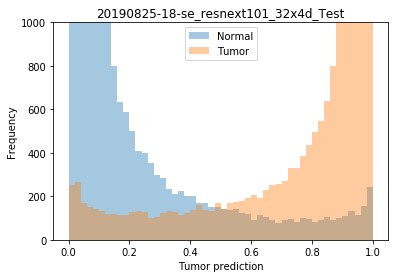

In [14]:
sns.distplot(df_inference[df_inference.isTumor == False].tumorProbs_all,  kde=False, label='Normal')
sns.distplot(df_inference[df_inference.isTumor == True].tumorProbs_all,  kde=False, label='Tumor')

plt.title(model_name)
plt.xlabel('Tumor prediction')
plt.ylabel('Frequency')
plt.ylim(0,1000)
plt.legend()

In [15]:
from sklearn.metrics import accuracy_score
def accuracyOnTh(th):
    preds = df_inference.tumorProbs_all.values > th
    trues = df_inference.isTumor.values
    return accuracy_score(trues, preds)

The best threshold is 0.4747474747474748


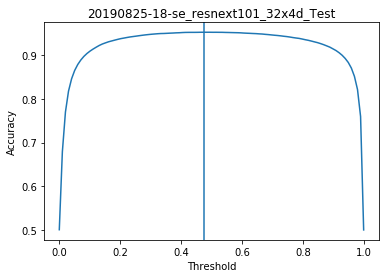

In [16]:
x = np.linspace(0.0,1.0,100)
y = [accuracyOnTh(xi) for xi in x]
plt.plot(x,y)
# get max acc
max_acc = 0.0
best_th = 0
for i in range(len(x)):
    if(y[i] > max_acc):
        max_acc = y[i]
        best_th = x[i]
plt.title(model_name)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.axvline(x=best_th)
print('The best threshold is {0}'.format(best_th))

In [17]:
# By weighting the precision over recall, we can avoid many false positives
from sklearn.metrics import fbeta_score
def fbetaOnTh(th, beta=0.5):
    preds = df_inference.tumorProbs_all.values > th
    trues = df_inference.isTumor.values
    return fbeta_score(trues, preds, beta=beta)

The best threshold is 0.7272727272727273


/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


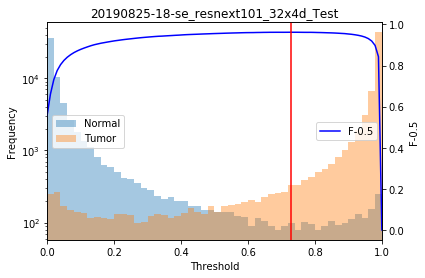

In [18]:
fig, ax1 = plt.subplots()

sns.distplot(df_inference[df_inference.isTumor == False].tumorProbs_all,  kde=False, label='Normal', ax=ax1)
sns.distplot(df_inference[df_inference.isTumor == True].tumorProbs_all,  kde=False, label='Tumor', ax=ax1)
ax1.set_yscale('log')
#plt.ylim(0,1000)
plt.xlim(0.0,1.0)

ax2 = ax1.twinx()

x = np.linspace(0.0,1.0,100)
y = [fbetaOnTh(xi) for xi in x]
ax2.plot(x,y, label='F-0.5', color='b')
# get max acc
max_acc = 0.0
best_th = 0
for i in range(len(x)):
    if(y[i] > max_acc):
        max_acc = y[i]
        best_th = x[i]


ax2.set_ylabel('F-0.5')
ax2.axvline(x=best_th, color='r')
print('The best threshold is {0}'.format(best_th))

plt.title(model_name)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Frequency')

ax1.legend(loc='center left')
ax2.legend(loc='center right')